# Time Series - Anomaly Detection
Goal: Look for anomalies in number of web pages accessed in a day by a user. Could it be a bot copying the curriculum?


Before looking by user, analyze over all users.

### Prepare environment w/ imports

In [1]:
#hides depreciation warnings
import warnings
warnings.filterwarnings("ignore")

#python libraries
import pandas as pd
import numpy as np

#visualizing data
import matplotlib.pyplot as plt

### Acquire

In [2]:
#label names of columns
colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']

#read file
df = pd.read_csv("anonymized-curriculum-access.txt", 
                 #separating the logs
                 sep="\s",
                 #no header in order to use colnames as header
                 header=None,
                 #use columns specified above
                 names = colnames, 
                 #specify which columns to use ([1] is `time` and not needed)
                 usecols=[0, 2, 3, 4, 5])

#take a look at df
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


### Prepare

In [3]:
#make date a datetime dtype
df.date = pd.to_datetime(df.date)

#set date as index
df = df.set_index(df.date)

#resample by day using 'endpoint' to be measured by count
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

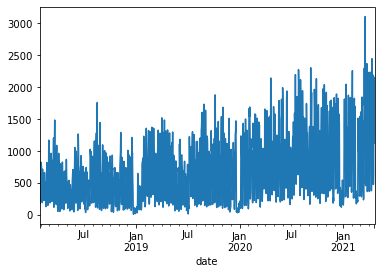

In [4]:
#visualize resampled pages data
pages.plot()

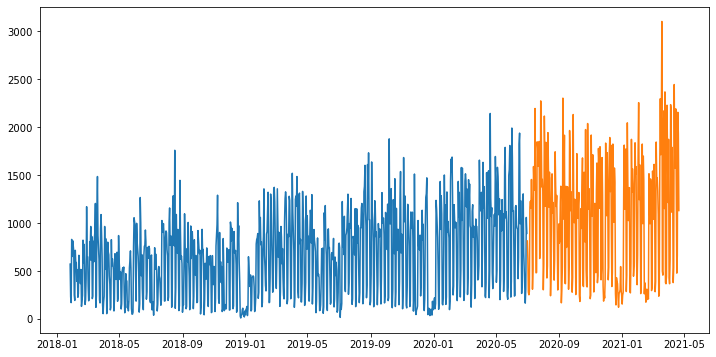

In [5]:
#setting an end point to train and a start point for test
end_train = '2020-06-30'
start_test = '2020-07-01'

#train starts from the beginning of data and ends at 6-30-2020
train = pages[:end_train]
#test starts after train ends and ends at the end of the data
test = pages[start_test:]

#visualize split
plt.figure(figsize=(12, 6))
plt.plot(train)
plt.plot(test)
plt.show()

In [6]:
#check if any nulls exist
pages.isnull().sum()

0

### Takeaways
- Looks like there may be an anomaly in that high spike around mid February.
- Little to no activities during the holidays.
- February snow storm aka 'snowpocalypse' week shows hardly any activity as well (lots of people lost electricty during that week 2/15/20 - 2/19/20). 
- No null values.





- No need to split because there is no modeling being done (just using statistics to identify low probability cases)
- But going to split for demonstration purposes below

## Exponential Moving Average
SMA time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units.

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this:

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where:
- M = Number of time periods, span of the window
- $t_{0}$ = Latest value (t nod, current, today's value)
- $t-1$ = Previous value (yesterday's)
- $EMA_{t-1}$ = Exponential moving average of previous day.
- The multiplier: $\alpha = \frac{2}{M+1}$ (weight)

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. So we just need to define the following:

- M = span argument = number of time periods. We will try 7 days, 14 days, and 30 days.
- Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value.

### For Demonstration Purposes (computing different spans):

In [7]:
#7 day EMA
ema_7d = train.ewm(span=7).mean()
ema_7d.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

In [8]:
#14 days EMA
ema_14d = train.ewm(span=14).mean()
ema_14d.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [9]:
#30 days EMA
ema_30d = train.ewm(span=30).mean()
ema_30d.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [10]:
#90 days EMA
ema_90d = train.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

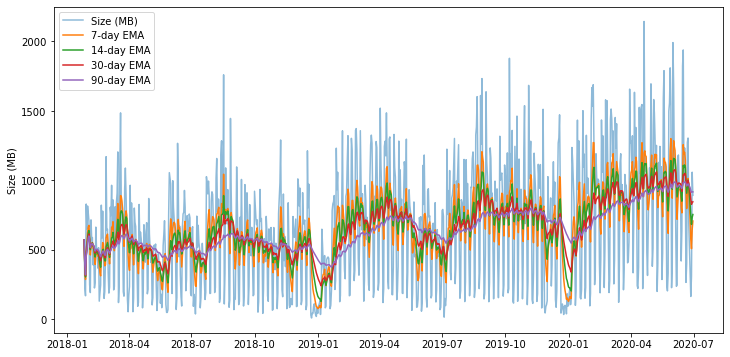

In [11]:
#setting the figure size
fig, ax = plt.subplots(figsize=(12,6))

#plotting full size 
ax.plot(train.index, train, label='Size (MB)', alpha=.5)

#plotting 7 day ema
ax.plot(train.index, ema_7d, label = '7-day EMA')
#plotting 14 day ema
ax.plot(train.index, ema_14d, label = '14-day EMA')
#plotting 30 day ema
ax.plot(train.index, ema_30d, label = '30-day EMA')
#plotting 90 day ema
ax.plot(train.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

### Takeaway
- The higher the EMA, the smoother the line, the easier it is to see patterns.

## Bollinger Bands and %b
#### Bollinger Bands
- a volatility indicator and commonly used in stock market trading.
- Made up of 3 lines, the **Upper Band (UB)**, the **Lower Band (LB)** and the **Midband**.

### Midband
- The Exponential Moving Average
- midband = `train.ewm(span=30).mean()` 
- span is number of time periods (span=30 is 30 days).

### Upper Band & Lower Band
- UB/LB = Midband + or - stdev * K
- (plus for upper) (minus for lower) (K is for weight)
- stdev = `train.ewm(span=30).std()`
- K = the number of standard deviations to go up and down from the EMA
- The noiser the data (the more data there is) the higher the K (weight) should be.

#### %b, Percent Bandwidth
- Shows where the last value sits in relation to the bands
- $\%b = \frac{last-LB}{UB-LB}$
- %b > 1 => point lies above UB (there's been a spike)
- %b < 0 => point lies below LB (there's been a dip)
- %b == .5 => point lies on the midband.

#### Bandwidth
- The width of the bands
- $Bandwidth = \frac{(UB-LB)}{Midband}$

In [12]:
#set the window span of 30 days
span = 30

#compute midband
midband = train.ewm(span=span).mean()

midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [13]:
#compute exponential stdev
stdev = train.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [14]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

print('upper band')
print(ub)
print('------------------------------------------')
print('lower band')
print(lb)

upper band
date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
                 ...     
2020-06-26    2434.413482
2020-06-27    2439.069749
2020-06-28    2407.028735
2020-06-29    2379.947762
2020-06-30    2333.252316
Freq: D, Name: endpoint, Length: 887, dtype: float64
------------------------------------------
lower band
date
2018-01-26           NaN
2018-01-27   -330.191557
2018-01-28   -326.494835
2018-01-29   -492.401124
2018-01-30   -352.070116
                 ...    
2020-06-26   -611.074347
2020-06-27   -712.075075
2020-06-28   -751.324040
2020-06-29   -694.417564
2020-06-30   -641.240195
Freq: D, Name: endpoint, Length: 887, dtype: float64


In [15]:
#concatenate ub and lb together into one df, bb (Bollinger Bands)
bb = pd.concat([ub, lb], axis=1)

#name columns
bb.columns = ['ub', 'lb']

bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [16]:
#add bb df to train df
train = pd.concat([train, midband, bb], axis=1)

#name columns
train.columns = ['pages', 'midband', 'ub', 'lb']

train.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


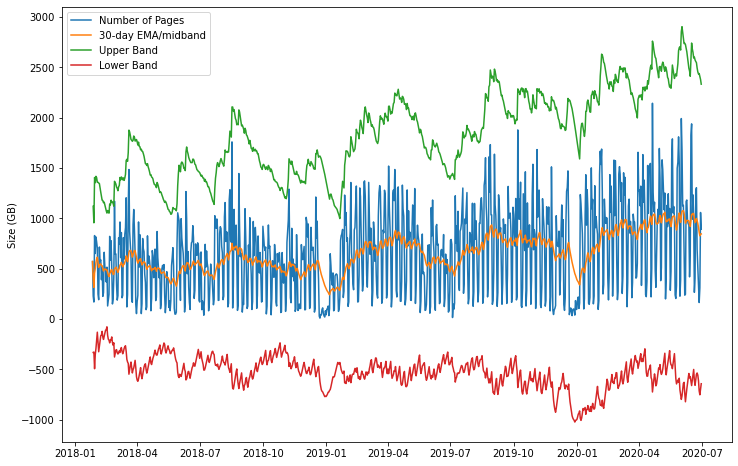

In [17]:
#plotting the bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train.pages, label='Number of Pages')

ax.plot(train.index, train.midband, label = '30-day EMA/midband')
ax.plot(train.index, train.ub, label = 'Upper Band')
ax.plot(train.index, train.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (GB)')

plt.show()

Compute %b

$\%b = \frac{last-LB}{UB-LB}$

Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b:

In [18]:
#get the last measure of gb
last_measure = train.iloc[-1].pages
last_measure

893.0

In [19]:
#get the lower band value on the last date
last_lb = train.iloc[-1].lb
last_lb

-641.2401949137454

In [20]:
#get the upper band value on the last date
last_ub = train.iloc[-1].ub
last_ub

2333.2523160975134

In [21]:
#can see the last values in pages, lb, and ub match output from above
train.tail()

,pages,midband,ub,lb
date,,,,
2020-06-26,357,911.669567,2434.413482,-611.074347
2020-06-27,165,863.497337,2439.069749,-712.075075
2020-06-28,311,827.852347,2407.028735,-751.324040
2020-06-29,1059,842.765099,2379.947762,-694.417564
2020-06-30,893,846.006061,2333.252316,-641.240195


In [22]:
#compute %b
last_pct_b = (last_measure - last_lb) / (last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.52


In [23]:
#compute for each point in time
train['pct_b'] = (train['pages'] - train['lb']) / (train['ub'] - train['lb'])

train.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


In [24]:
#Where do we see anomalies?
#search for %b values > 1, 
#no need to search for values < 0 b/c a low extreme is not something to be concerned about w/ this example.
train[train['pct_b'] > 1]

,pages,midband,ub,lb,pct_b
date,,,,,


### Takeaways
- No anomalies in example above. 
- Weight can be changed to find anomalies.

***
## Pulling it all together!
1. Acquire
2. Prepare with user
3. Compute features
    - compute midband
    - compute standard deviation
    - compute upper & lower band
    - create df with metrics
    - compute %b
    - add user_id to dataframe
4. Plot
5. Search for anomalies

In [25]:
#step 1: acquire data
def acquire(file_name, column_names):
    '''
    This function takes in the name of file and column names as arguments
    and uses pandas read_csv function to return a df with specified file_name and column_names
    '''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])


#step 2: prepare w/ user
def prep(df, user):
    '''
    This function takes in a dataframe and user as arguments,
    filters by user,
    converts date column a datetime dtype, 
    sets date as index,
    resamples by day using 'endpoint' to be measured by count,
    
    and returns prepped pages
    '''
    #filter by user
    df = df[df.user_id == user]
    #convert date col to datetime 
    df.date = pd.to_datetime(df.date)
    #set date as index
    df = df.set_index(df.date)
    #resample by day using endpoint to be measured by count to get pages var
    pages = df['endpoint'].resample('d').count()
    
    return pages


#step 3: compute features and %b
def compute_pct_b(pages, span, weight, user):
    '''
    This function takes in pages, span, weight, and user as arguments,
    
    computes the midband, stdev, upper band, lower band,
    creates df with the metrics,
    computes %b,
    adds %b column and user_id to df
    
    and returns my_df
    '''
    #compute metrics: midband, stdev, upper/lower band
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    #create df w/ the above metrics:
    #concatenate ub & lb into one df, bb (bollinger bands)
    bb = pd.concat([ub, lb], axis=1)
    #concatenate bb df to my_df
    my_df = pd.concat([pages, midband, bb], axis=1)
    #name columns in my_df
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    
    #compute %b and add to my_df
    my_df['pct_b'] = (my_df['pages'] - my_df['lb']) / (my_df['ub'] - my_df['lb'])
    
    #add user_id to my_df
    my_df['user_id'] = user
    
    return my_df


#step 4: plot bands
def plt_bands(my_df, user):
    '''
    This function will take my_df and user as arguments,
    
    set the figure size, 
    plot full size of pages along w/ user, 
    plot midband, upper/lower bands,
    set legend location,
    name y label, 
    
    and return plots by user
    '''
    #setting the figure size
    fig, ax = plt.subplots(figsize=(12,8))
    #plotting full size of pages along with user
    ax.plot(my_df.index, my_df.pages, label = 'Number of Pages, User: '+str(user))
    #plotting midband
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    #plotting upper band
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    #plotting lower band
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    #setting best location for the legend
    ax.legend(loc = 'best')
    #naming y label
    ax.set_ylabel('Number of Pages')
    
    #plot by user
    plt.show()
    
    
#step 5: search for anomalies    
def find_anomalies(df, user, span, weight):
    '''
    This function takes in original acquired df, 
                            user (to search anomalies for), 
                            span (of the moving average), 
                            and weight (for bollinger bands) as arguments, 
    preps with user to obtain pages series, 
    computes %b on pages using span and weight for the user,
    plots the bands,
    
    and returns a df of values > 1
    '''
    #get pages series by calling prep function
    pages = prep(df, user)
    #get my_df by calling compute_pct_b function
    my_df = compute_pct_b(pages, span, weight, user)
    #plot by calling plt_bands function
    # plt_bands(my_df, user)
    
    return my_df[my_df.pct_b > 1]


#### Acquire

In [26]:
#specify file name and column names
file_name = "anonymized-curriculum-access.txt"
column_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']

#acquire df by using acquire function
df = acquire(file_name, column_names)
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


#### Test on a single user

In [27]:
#specify user, span, weight
user = 1
span = 30
weight = 3

#create empty dataframe
anomalies = pd.DataFrame()

#use find_anomalies function to create user_df
user_df = find_anomalies(df, user, span, weight)

#concatenate user_df to empty anomalies df (axis=0 to add rows)
anomalies = pd.concat([anomalies, user_df], axis=0)
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-02-20,54,6.456745,50.349000,-37.435509,1.041590,1
2018-05-29,68,9.612443,62.374629,-43.149742,1.053309,1
2018-11-07,13,1.221442,11.524503,-9.081619,1.071605,1
2018-12-19,25,2.880262,22.002760,-16.242235,1.078369,1
2019-01-29,44,3.623334,36.587343,-29.340675,1.112436,1
2019-07-08,101,8.248768,83.899086,-67.401549,1.113026,1
2020-01-15,41,6.259332,39.731193,-27.212529,1.018953,1
2021-01-05,40,4.050795,35.348264,-27.246673,1.074315,1
2021-04-15,52,9.075259,50.177299,-32.026781,1.022173,1


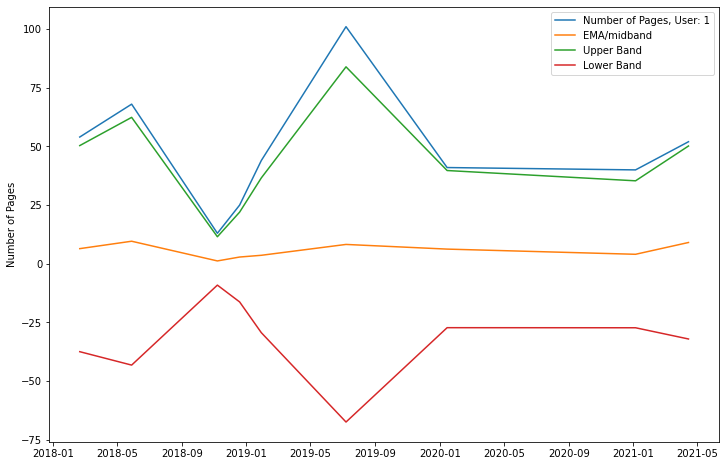

In [28]:
#plot by calling plt_bands function
plt_bands(user_df, user)

#### Test by looping through every user

In [29]:
#specify span and weight
span = 30
weight = 3.5

#create empty df
anomalies = pd.DataFrame()

#loop through every user to find anomalies
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)
    
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3
...,...,...,...,...,...,...
2021-01-24,7,0.574393,6.857226,-5.708440,1.011362,817
2021-03-25,59,6.824556,58.415342,-44.766230,1.005666,843
2021-02-23,67,8.229409,66.322904,-49.864086,1.005828,851


In [30]:
#value counts show some users could be instructors 
#can add some filters/rules to eliminate instructors
anomalies.user_id.value_counts()

88     12
80     11
146    11
18     10
79      9
       ..
535     1
538     1
214     1
213     1
859     1
Name: user_id, Length: 413, dtype: int64